# Ujednoznacznianie sensu słów (WSD)

## Ujednoznacznianie poprzez podobieństwo do definicji ze Słowosieci

### Wczytanie jednostek i synsetów

**Uwaga:** Poniżej wykorzystana jest Słowosieć w wersji 3.0, która dostępna jest bezpośrednio z użytego linku. Pobranie nowszej wersji, tj. 4.2 jest możliwe, ale wymaga wypełnienia formularza dostępnego pod linkiem: http://plwordnet.pwr.edu.pl/wordnet/download

In [1]:
!wget -O plwordnet_3_0.7z https://clarin-pl.eu/dspace/bitstream/handle/11321/273/plwordnet_3_0.7z?sequence=2&isAllowed=y

--2021-01-03 16:53:11--  https://clarin-pl.eu/dspace/bitstream/handle/11321/273/plwordnet_3_0.7z?sequence=2
Resolving clarin-pl.eu (clarin-pl.eu)... 156.17.135.38
Connecting to clarin-pl.eu (clarin-pl.eu)|156.17.135.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36119839 (34M) [application/octet-stream]
Saving to: ‘plwordnet_3_0.7z’

plwordnet_3_0.7z    100%[===================>]  34.45M  15.4MB/s    in 2.2s    

2021-01-03 16:53:14 (15.4 MB/s) - ‘plwordnet_3_0.7z’ saved [36119839/36119839]



In [2]:
!7z x plwordnet_3_0.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 36119839 bytes (35 MiB)

Extracting archive: plwordnet_3_0.7z
--
Path = plwordnet_3_0.7z
Type = 7z
Physical Size = 36119839
Headers Size = 313
Method = LZMA:25
Solid = +
Blocks = 1

  0%      5% 1 - plwordnet_3_0/plwordnet-3.0-visdisc.xml                                                 11% 1 - plwordnet_3_0/plwordnet-3.0-visdisc.xml                                                 15% 1 - plwordnet_3_0/plwordnet-3.0-visdisc.xml                                               

In [3]:
import xml.etree.ElementTree as ET

tree = ET.fromstring(open("plwordnet_3_0/plwordnet-3.0.xml", "r").read())

**Opis synsetów**

    <synset id="238955" workstate="Nie przetworzone" split="1" owner=""
        definition="" desc="" abstract="false">
        <unit-id>371013</unit-id>
        <unit-id>371014</unit-id>
    </synset>

In [4]:
luid_to_synsetid = {}

for s in tree.iter('synset'):
  id = s.attrib.get('id')
  for lu in s.iter("unit-id"):
    luid_to_synsetid[lu.text] = id

len(luid_to_synsetid)

477881

**Opis jednostki leksykalnej**

    <lexical-unit id="1599" name="ekran" pos="rzeczownik" tagcount="718"
        domain="msc"
        desc="##K: og. ##D: płaszczyzna, na którą rzuca się obraz, np. w kinie."
        workstate="Sprawdzone" source="systemowy" variant="3"/>


In [5]:
import re
from collections import namedtuple

LexicalUnit = namedtuple('LexicalUnit', 'id name desc variant synset_id')

lexical_units = {}

definition_regex = re.compile("##D:([^#]+)")

for unit in tree.iter('lexical-unit'):
    id = unit.attrib.get('id')
    name = unit.attrib.get('name')
    desc = unit.attrib.get('desc')    
    definitions = []
    for m in definition_regex.finditer(desc):
      definition = m.group(1).strip()
      if len(definition) > 3:
        definitions.append(definition)
    variant = unit.attrib.get('variant')
    lexical_units[id] = LexicalUnit(id, name, definitions, variant, luid_to_synsetid[id])

len(lexical_units)

477881

### Pobranie znaczeń z opisu jednostek leksykalnych

In [6]:
units = [item for item in lexical_units.values() if item.name == "ekran"]
units

[LexicalUnit(id='1599', name='ekran', desc=['płaszczyzna, na którą rzuca się obraz, np. w kinie.'], variant='3', synset_id='4879'),
 LexicalUnit(id='1600', name='ekran', desc=['osłona pełniąca funkcję zabezpieczenia, izolacji przed czymś szkodliwym.'], variant='4', synset_id='8264'),
 LexicalUnit(id='380963', name='ekran', desc=['rodzaj zasłony (z tkaniny, skóry, żelaza), która bywa ustawiana przed kominkiem.'], variant='6', synset_id='248273'),
 LexicalUnit(id='19744', name='ekran', desc=['wyświetlacz; powierzchnia, na której jest coś wyświetlane.'], variant='1', synset_id='799'),
 LexicalUnit(id='371009', name='ekran', desc=['duża naszywka z nazwą zespołu, która pasuje na środkowy klin jeansowej kurtki lub kamizelki.'], variant='5', synset_id='238951')]

### Porównanie zdania z definicją


In [7]:
!pip install spacy -U
!python -m spacy download pl_core_news_lg
!python -m spacy link pl_core_news_lg pl_core_news_lg -f

import spacy
nlp = spacy.load('pl_core_news_lg')

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.5)
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_lg')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pl_core_news_lg -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pl_core_news_lg
You can now load the model via spacy.load('pl_core_news_lg')


In [8]:
text = "Jak włączyłem komputer to na ekranie wyświetlił się komunikat o błędzie"

In [9]:
doc = nlp(text.replace("ekranie", "_"))
doc

Jak włączyłem komputer to na _ wyświetlił się komunikat o błędzie

In [10]:
sims = [(doc.similarity(nlp(", ".join(sense.desc))), sense) for sense in units]
sims = sorted(sims, reverse=True)
for sim, lu in sims:
  print("%5.2f  %s" % (sim, str(lu)))

 0.62  LexicalUnit(id='1599', name='ekran', desc=['płaszczyzna, na którą rzuca się obraz, np. w kinie.'], variant='3', synset_id='4879')
 0.61  LexicalUnit(id='19744', name='ekran', desc=['wyświetlacz; powierzchnia, na której jest coś wyświetlane.'], variant='1', synset_id='799')
 0.40  LexicalUnit(id='371009', name='ekran', desc=['duża naszywka z nazwą zespołu, która pasuje na środkowy klin jeansowej kurtki lub kamizelki.'], variant='5', synset_id='238951')
 0.35  LexicalUnit(id='1600', name='ekran', desc=['osłona pełniąca funkcję zabezpieczenia, izolacji przed czymś szkodliwym.'], variant='4', synset_id='8264')
 0.29  LexicalUnit(id='380963', name='ekran', desc=['rodzaj zasłony (z tkaniny, skóry, żelaza), która bywa ustawiana przed kominkiem.'], variant='6', synset_id='248273')


## Usługa sieciowa CLARIN-PL do WSD

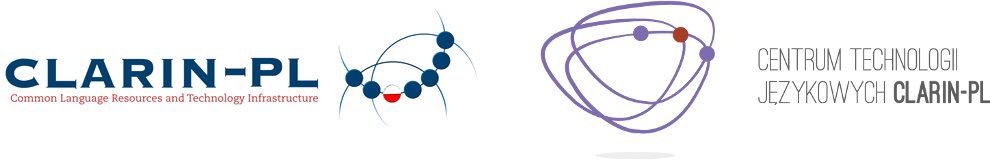

http://ws.clarin-pl.eu/wsd.shtml

In [11]:
import requests
import json
import time

In [12]:
clarin_url = "http://ws.clarin-pl.eu/nlprest2/base"

### Notacja LPMN

Służy do opisu potoku przetwarzania do wykonania przez infrastrukturę CLARIN-PL.

In [13]:
lpmn = "wcrft2|wsd"

### Rozpoczęcie zadania

In [14]:
url = f"{clarin_url}/startTask"
payload = {'lpmn': lpmn, 'user': "user@mail.com", "text": text}
headers = {'content-type': 'application/json'}
task_id = requests.post(url, data=json.dumps(payload), headers=headers).text
task_id


'7d942718-a0b1-4e0d-8dc5-fd2b5bf512fa'

### Sprawdzanie statusu

In [16]:
data = json.loads(requests.get(f"{clarin_url}/getStatus/{task_id}").text)
while data["status"] == "QUEUE" or data["status"] == "PROCESSING" :
    time.sleep(0.5);
    data = json.loads(requests.get(f"{clarin_url}/getStatus/{task_id}").text)
if data["status"]=="ERROR":
    print("Error "+data["value"]);
data

{'status': 'DONE',
 'value': [{'fileID': '/requests/wsd/510107e1-7b38-4f36-ab9c-45a11eae237b',
   'name': 'file'}]}

In [17]:
file_id = data["value"][0]["fileID"]
file_id

'/requests/wsd/510107e1-7b38-4f36-ab9c-45a11eae237b'

### Pobranie wyniku

In [18]:
content = requests.get(f"{clarin_url}/download{file_id}").text;
content

'<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE chunkList SYSTEM "ccl.dtd">\n<chunkList>\n <chunk id="ch1" type="p">\n  <sentence id="s1">\n   <tok>\n    <orth>Jak</orth>\n    <lex disamb="1"><base>jak</base><ctag>conj</ctag></lex>\n   </tok>\n   <tok>\n    <orth>włączył</orth>\n    <lex disamb="1"><base>włączyć</base><ctag>praet:sg:m1:perf</ctag></lex>\n    <prop key="sense:ukb:syns_id">48966</prop>\n    <prop key="sense:ukb:syns_rank">48966/577.5525341494 58418/514.4603593961 49335/509.2135768364 58417/498.2802642697 58419/486.9991529866 58421/454.0202309927</prop>\n    <prop key="sense:ukb:unitsstr">włączyć.4(33:dtk)</prop>\n   </tok>\n   <ns/>\n   <tok>\n    <orth>em</orth>\n    <lex disamb="1"><base>być</base><ctag>aglt:sg:pri:imperf:wok</ctag></lex>\n   </tok>\n   <tok>\n    <orth>komputer</orth>\n    <lex disamb="1"><base>komputer</base><ctag>subst:sg:nom:m3</ctag></lex>\n    <prop key="sense:ukb:syns_id">1316</prop>\n    <prop key="sense:ukb:syns_rank">1316/3102.6248820179</

### Parsowanie wyniku

**Struktura dokumentu CCL**
```
chunkList > chunk > sentence > tok
```

**Opis tokenu**

```
<tok>
  <orth>ekranie</orth>
  <lex disamb="1"><base>ekran</base><ctag>subst:sg:loc:m3</ctag></lex>
  <prop key="sense:ukb:syns_id">799</prop>
  <prop key="sense:ukb:syns_rank">799/716.8401395396 4879/613.7120669728 8264/607.2423543292 248273/535.6587927327 238951/521.3461699812</prop>
  <prop key="sense:ukb:unitsstr">ekran.1(3:wytw) ekran_wizyjny.1(3:wytw)</prop>   
</tok>
```



In [19]:
import xml.etree.ElementTree as ET

ccl = ET.fromstring(content)

In [20]:
for token in ccl.iter("tok"):
  orth = token.find("orth").text
  if orth == "ekranie": 
    for prop in token.iter("prop"):
        print(prop.text)

799
799/716.8401395396 4879/613.7120669728 8264/607.2423543292 248273/535.6587927327 238951/521.3461699812
ekran.1(3:wytw) ekran_wizyjny.1(3:wytw)
